In [1]:
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

2023-07-02 00:17:48.451885: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-02 00:17:48.526914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-07-02 00:17:48.526941: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-07-02 00:17:48.526946: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1500] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-02 00:17:48.563026: I tensorflow/core/platform/cpu_feature_g

In [2]:
root_dir = './Dataset/'
folders = glob.glob(root_dir+"/*")
classes = [folder.split('/')[-1] for folder in folders]
num_classes = len(classes)

# Dict of characters and corresponding values {'ا': 0, 'ب': 1...}
ara_alpha_numeric = dict([(v,k) for k,v in enumerate(np.sort(classes))])

# Desired image size
img_rows, img_cols = 28, 28

# Prepare X_train, X_test, Y_train, Y_test
x_train = []
x_test = []
y_train = []
y_test = []

for folder in folders:
    cls = folder.split('/')[-1]
    # Retrieve all images in the character's folder, resize to 28,28
    files = glob.glob(folder+"/*")
    images =  np.array([cv2.resize(cv2.imread(f,cv2.IMREAD_GRAYSCALE), dsize=(img_rows,img_cols), interpolation=cv2.INTER_CUBIC) for f in files])
    labels = np.asarray([ara_alpha_numeric[cls]]*images.shape[0])
    # Split images 80:20 train:test
    idx = int(images.shape[0]* 0.8)
    images_train = images[:idx , :]
    labels_train = labels[:idx]
    images_test = images[idx: , :]
    labels_test = labels[idx:]
    # Return in main lists
    x_train.append(images_train)
    x_test.append(images_test)
    y_train.append(labels_train)
    y_test.append(labels_test)
    
    print("Done with: " + folder)

# Reshape lists to prep for training
x_train = np.concatenate(x_train,axis=0)
x_test = np.concatenate(x_test,axis=0)
y_train = np.concatenate(y_train,axis=0)
y_test = np.concatenate(y_test,axis=0)

Done with: ./Dataset/ا
Done with: ./Dataset/ب
Done with: ./Dataset/ت
Done with: ./Dataset/ث
Done with: ./Dataset/ج
Done with: ./Dataset/ح
Done with: ./Dataset/خ
Done with: ./Dataset/د
Done with: ./Dataset/ذ
Done with: ./Dataset/ر
Done with: ./Dataset/ز
Done with: ./Dataset/س
Done with: ./Dataset/ش
Done with: ./Dataset/ص
Done with: ./Dataset/ض
Done with: ./Dataset/ط
Done with: ./Dataset/ظ
Done with: ./Dataset/ع
Done with: ./Dataset/غ
Done with: ./Dataset/ف
Done with: ./Dataset/ق
Done with: ./Dataset/ك
Done with: ./Dataset/ل
Done with: ./Dataset/لا
Done with: ./Dataset/م
Done with: ./Dataset/ن
Done with: ./Dataset/ه
Done with: ./Dataset/و
Done with: ./Dataset/ي
Done with: ./Dataset/٠
Done with: ./Dataset/١
Done with: ./Dataset/٢
Done with: ./Dataset/٣
Done with: ./Dataset/٤
Done with: ./Dataset/٥
Done with: ./Dataset/٦
Done with: ./Dataset/٧
Done with: ./Dataset/٨
Done with: ./Dataset/٩


In [3]:
# Verify input shape
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(x_test.shape)

(77376, 28, 28)
(19373, 28, 28)
(77376,)
(19373, 28, 28)


In [4]:
# Reshape input for CNN architecture
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Convert input to float for weight multiplication
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Verify input was reshaped
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (77376, 28, 28, 1)
x_test shape: (19373, 28, 28, 1)
y_train shape: (77376,)
y_test shape: (19373,)
77376 train samples
19373 test samples


In [5]:
# Simple Keras architecture for MNIST 
# Source: https://stackoverflow.com/questions/62033143/significantly-higher-testing-accuracy-on-mnist-with-keras-than-tensorflow-keras

batch_size = 128
epochs = 10

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.optimizers.Adadelta(learning_rate=1.0),
    metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2023-07-02 00:18:08.519473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 00:18:08.564198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 00:18:08.564310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/10


2023-07-02 00:18:09.287810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-02 00:18:09.385914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8902
2023-07-02 00:18:09.648876: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c088828d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-02 00:18:09.648893: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A3000 12GB Laptop GPU, Compute Capability 8.6
2023-07-02 00:18:09.666908: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-02 00:18:09.741854: I ./tensorflow/compiler/jit/device_compiler.h:

605/605 [==============================] - 6s 8ms/step - loss: 0.3798 - accuracy: 0.8941 - val_loss: 0.0642 - val_accuracy: 0.9837
Epoch 2/10
605/605 [==============================] - 5s 8ms/step - loss: 0.0862 - accuracy: 0.9748 - val_loss: 0.0366 - val_accuracy: 0.9912
Epoch 3/10
605/605 [==============================] - 5s 8ms/step - loss: 0.0583 - accuracy: 0.9835 - val_loss: 0.0296 - val_accuracy: 0.9931
Epoch 4/10
605/605 [==============================] - 5s 8ms/step - loss: 0.0442 - accuracy: 0.9872 - val_loss: 0.0252 - val_accuracy: 0.9943
Epoch 5/10
605/605 [==============================] - 5s 8ms/step - loss: 0.0370 - accuracy: 0.9897 - val_loss: 0.0254 - val_accuracy: 0.9942
Epoch 6/10
605/605 [==============================] - 5s 8ms/step - loss: 0.0320 - accuracy: 0.9910 - val_loss: 0.0236 - val_accuracy: 0.9946
Epoch 7/10
605/605 [==============================] - 4s 7ms/step - loss: 0.0279 - accuracy: 0.9922 - val_loss: 0.0241 - val_accuracy: 0.9941
Epoch 8/10
605/60

606/606 [==============================] - 1s 1ms/step


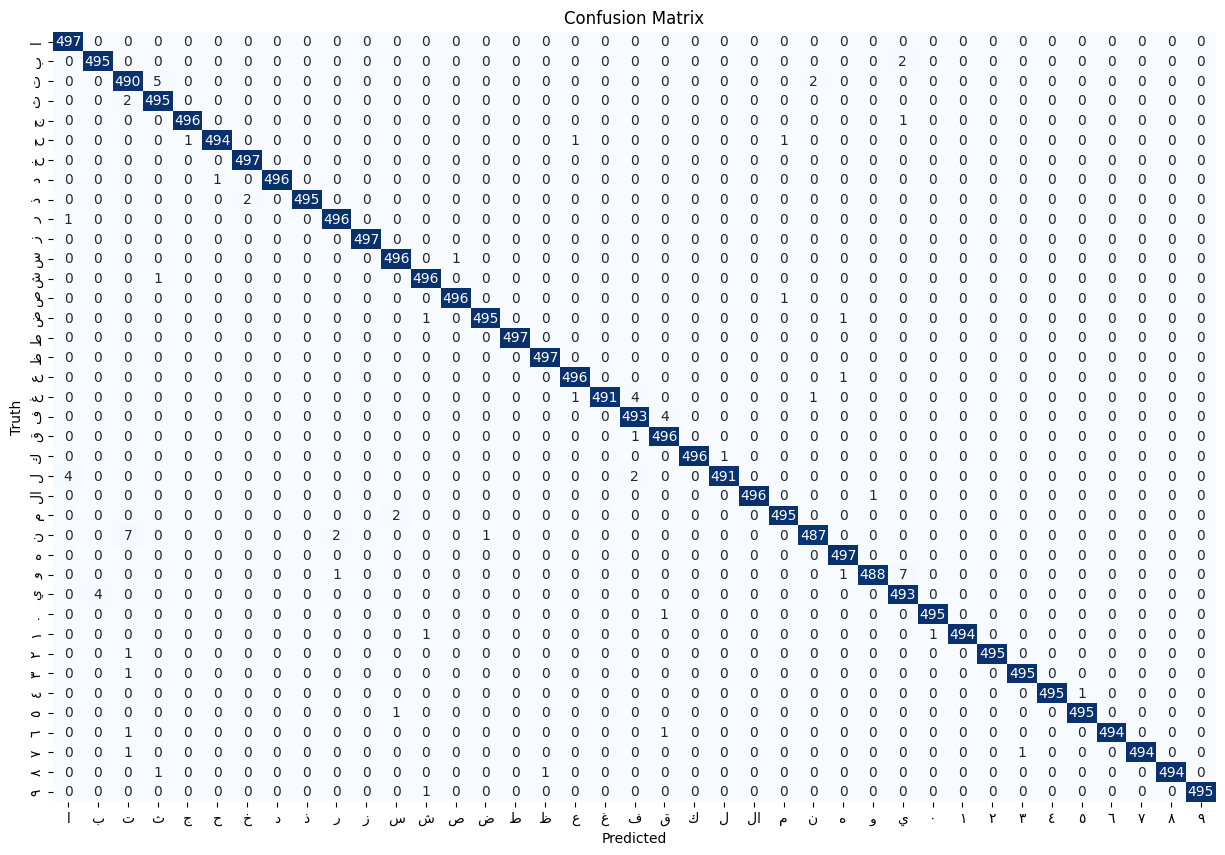

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
# Confusion matrix
cf_matrix = tf.math.confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1))
sns.heatmap(cf_matrix, cbar=False, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes).set(title="Confusion Matrix", xlabel="Predicted", ylabel="Truth")
plt.savefig('cm.png')

In [6]:
# Saving the model
model.save("model.h5")              
print("Model Saved Successfully!")

Model Saved Successfully!


/home/Medo/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Load the model
model = load_model('model.h5')

# Preprocess image before testing
def processed_image(imgpath):
    img = cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, dsize=(img_rows,img_cols), interpolation=cv2.INTER_CUBIC)
    img = img.reshape(1, img_rows, img_cols, 1).astype('float32')
    img /= 255
    return img

print(ara_alpha_numeric)
# Grab random samples
test_img1 = processed_image('./Dataset/ص/15.png')

# Test Samples
prediction = model.predict(test_img1)
print(list(ara_alpha_numeric.keys())[list(ara_alpha_numeric.values()).index(prediction.argmax(axis=-1)[0])])

{'ا': 0, 'ب': 1, 'ت': 2, 'ث': 3, 'ج': 4, 'ح': 5, 'خ': 6, 'د': 7, 'ذ': 8, 'ر': 9, 'ز': 10, 'س': 11, 'ش': 12, 'ص': 13, 'ض': 14, 'ط': 15, 'ظ': 16, 'ع': 17, 'غ': 18, 'ف': 19, 'ق': 20, 'ك': 21, 'ل': 22, 'لا': 23, 'م': 24, 'ن': 25, 'ه': 26, 'و': 27, 'ي': 28, '٠': 29, '١': 30, '٢': 31, '٣': 32, '٤': 33, '٥': 34, '٦': 35, '٧': 36, '٨': 37, '٩': 38}
1/1 [==============================] - 0s 92ms/step
ص
